# Adversarial Training Project

In this project, I explore the implementation and training of models using adversarial training. Adversarial training is a technique used to improve the robustness of machine learning models against adversarial examples. Adversarial examples are inputs to a machine learning model that are intentionally designed to cause the model to make a mistake.

This project aims to implement adversarial training on the CIFAR-10 dataset and evaluate its effectiveness in improving model robustness. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. We will generate adversarial examples and incorporate them into the training process to strengthen the model's defenses against such inputs.

## Setup

In [1]:
!pip install umap-learn diffusers # tqdm torch torchvision #numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import umap.umap_ as umap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preparation

The first step in our project is to prepare the data. We will use the CIFAR-10 dataset, which is commonly used for image classification tasks. This dataset consists of 60,000 32x32 color images in 10 classes, with 50,000 training images and 10,000 test images.

### Preprocessing

We will preprocess the data by normalizing the images to have pixel values between 0 and 1. Additionally, we may apply data augmentation techniques such as random cropping, flipping, and rotation to increase the diversity of the training data.

In [3]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 72383674.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, idx, transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self, index):
        image, label = self.data[index]
        if(self.transforms != None):
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.data)

# Split data and create the dataloader
train_idx, val_idx = train_test_split(list(range(len(cifar_trainset))), train_size=Train_SIZE)
train_dataset = Cifar10Dataset(cifar_trainset, train_idx, cifar_transforms)

# Subsample the remaining data further to create a smaller validation set
val_idx_2, _ = train_test_split(val_idx, train_size=0.0625)
val_dataset = Cifar10Dataset(cifar_trainset, val_idx_2, cifar_transforms)

# Create the test dataset
test_dataset = Cifar10Dataset(cifar_testset, list(range(len(cifar_testset))), cifar_transforms)

BATCH_SIZE = 64 # TODO: Smaller batch size would reduce GPU usage?
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

assert len(train_dataset) == 10000
assert len(val_dataset) == 2500
assert len(test_dataset) == 10000

## Define Resnet18 Model

We define a Resnet18 model with a custom classification head (for the 10 classes of the CIFAR-10 dataset). We use this model multiple times to see the effect of attacks and adversarial training.

In [5]:
class Resnet18(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)

        # Classification head
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)

## Helper methods

Here we define some helper methods to train and test the models.

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=10):
    # Initialize early stopping variables
    best_val_accuracy = 0
    epochs_since_improvement = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training") as tbar:
            for batch_idx, (inputs, targets) in enumerate(tbar):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)
                tbar.set_postfix(loss=(train_loss/(batch_idx + 1)), accuracy=100.*correct/total)

        train_loss /= len(train_loader)
        train_accuracy = 100. * correct / total

        # Validation phase (with early stopping check)
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad(), tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation") as vbar:
            for batch_idx, (inputs, targets) in enumerate(vbar):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)
                vbar.set_postfix(loss=(val_loss/(batch_idx + 1)), accuracy=100.*correct/total)

        val_loss /= len(val_loader)
        val_accuracy = 100. * correct / total

        # Check for improvement
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        # Early stopping condition
        if epochs_since_improvement > patience:
            print(f"Stopping early at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
            break

    torch.save(model.state_dict(), 'q1_base_model.pth')
    return train_loss, train_accuracy, val_loss, val_accuracy

In [7]:
def test(model, data_loader, criterion, optimizer, attack=False):
    average_test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Switch to evaluation mode
    model.eval()

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update stats
            average_test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(targets).sum().item()
            total_predictions += targets.size(0)

            test_tqdm.set_postfix({
                'loss': average_test_loss/(batch_idx+1),
                'accuracy': 100. * correct_predictions / total_predictions
            })

    average_test_loss /= len(data_loader)
    accuracy = 100. * correct_predictions / total_predictions

    print(f"Testing completed: Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return average_test_loss, accuracy

In [8]:
def extract_features(model, data_loader):
    # Extract the features from the model
    feature_extraction_model = nn.Sequential(
        model.resnet.conv1,
        model.resnet.bn1,
        model.resnet.relu,
        model.resnet.maxpool,
        model.resnet.layer1,
        model.resnet.layer2,
        model.resnet.layer3,
        model.resnet.layer4,
        model.resnet.avgpool
    )

    # Switch to evaluation mode
    feature_extraction_model.eval().to(device)

    features = []
    labels = []
    with torch.no_grad():
        with tqdm(data_loader, desc ="   extract features") as extract_tqdm:
            for batch_idx, (inputs, targets) in enumerate(extract_tqdm):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = feature_extraction_model(inputs)

                # Reshape the outputs to 2D before converting to numpy and appending
                outputs_reshaped = outputs.view(outputs.size(0), -1).cpu().numpy()

                features.append(outputs_reshaped)
                labels.append(targets.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels

def plot_umap(features, y):
    # Reduce the dimensionality with UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_features = reducer.fit_transform(features)

    # Plot the reduced features
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y, cmap='tab10', s=10)
    plt.gca().set_aspect('equal', 'datalim')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    # cbar.set_ticklabels([
    #     'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    #     'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
    # ])
    plt.title('UMAP projection of the CIFAR-10 dataset', fontsize=24)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

Finally, use the functions defined above to train a ResNet18 model (without attacks) and visualize the features in 2D.

In [9]:
# Train the ResNet18 model
num_classes = 10
model = Resnet18(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100

average_train_loss, train_acc, average_val_loss, val_acc = train(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)
average_test_loss, test_acc = test(model, test_loader, criterion, optimizer)

print(f"Training loss: {average_train_loss}, accuracy: {train_acc}")
print(f"Validation loss: {average_val_loss}, accuracy: {val_acc}")
print(f"Test loss: {average_test_loss}, accuracy: {test_acc}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s]
Epoch 33/100 - Validation: 100%|██████████| 40/40 [00:01<00:00, 39.52it/s, accuracy=71.6, loss=1.59]


Stopping early at epoch 33. No improvement in validation accuracy for 10 consecutive epochs.


   test: 100%|██████████| 157/157 [00:04<00:00, 35.70it/s, loss=1.52, accuracy=71.8]

Testing completed: Loss: 1.5176, Accuracy: 71.78%
Training loss: 0.034221119516541006, accuracy: 98.96
Validation loss: 1.5933036923408508, accuracy: 71.64
Test loss: 1.517621033890232, accuracy: 71.78


Extracting features...


   extract features: 100%|██████████| 157/157 [00:04<00:00, 38.84it/s]
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Plotting...


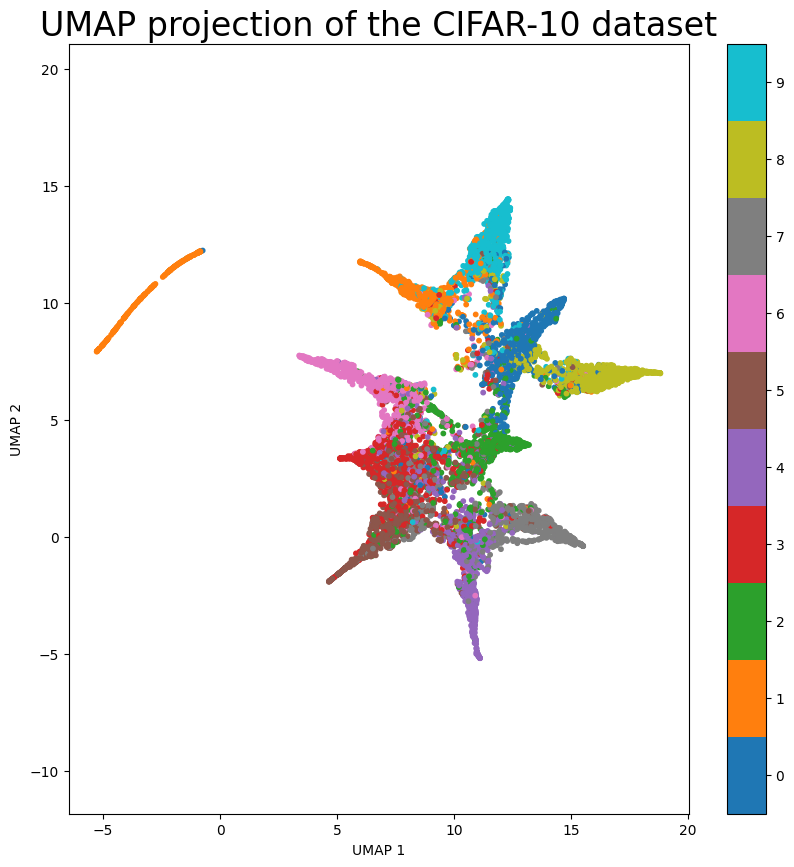

In [10]:
print("Extracting features...")

features, labels = extract_features(model, test_loader)

print("Plotting...")

plot_umap(features, labels)

Notice that there are clearly identifiable clusters of points (for the most part). It would be easier to see it in higher dimensions, but this plot still shows us that the classifier is performing well.

## Adversarial Training

In this section, we first augment the data with some standard transformations such as adding Gaussian noise, color jitter, etc. Then, we attack the data using the Fast Sign Gradient Method (FGSM) attack and then evaluate the model on it to see the effect of the attack. We expect the accuracy to go down. We use the cleverhans library for this purpose.

In [11]:
!pip install git+https://github.com/cleverhans-lab/cleverhans.git#egg=cleverhans

  Cloning https://github.com/cleverhans-lab/cleverhans.git to /tmp/pip-install-dtcm8b42/cleverhans_aa34e40cd2f1464dbf5b77e7d0a35df8
  Running command git clone --filter=blob:none --quiet https://github.com/cleverhans-lab/cleverhans.git /tmp/pip-install-dtcm8b42/cleverhans_aa34e40cd2f1464dbf5b77e7d0a35df8
  Resolved https://github.com/cleverhans-lab/cleverhans.git to commit 574efc1d2f5c7e102c78cf0e937654e847267522
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.9 MB/s eta 0:00:00
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92397 sha256=e0371f9fa435792168a486368d367e5d6db3a809a7651a3fccf9ac352ee810e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-gcusf5f9/wheels/bd/03/cf/b4e2deb9865a197040bfe42a9ab14910edbce1e760ae20b034
Successfully built cleverhans


In [12]:
augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)), # Add Gaussian noise
    transforms.RandomHorizontalFlip(),
])

# Apply augmentations to test dataset
test_dataset_augmented = Cifar10Dataset(cifar_testset, list(range(len(cifar_testset))), transforms=augmentation)
test_loader_augmented = torch.utils.data.DataLoader(test_dataset_augmented, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

def generate_fgm_examples(model, data_loader, criterion, epsilon=4/255):
    feature_extraction_model = nn.Sequential(
        model.resnet.conv1,
        model.resnet.bn1,
        model.resnet.relu,
        model.resnet.maxpool,
        model.resnet.layer1,
        model.resnet.layer2,
        model.resnet.layer3,
        model.resnet.layer4,
        model.resnet.avgpool
    )
    feature_extraction_model.eval().to(device)

    model.eval()

    examples = []
    labels = []

    average_test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)

            # Part 1: Create perturbed data (adversarial examples)
            perturbed_data = fast_gradient_method(model, inputs, epsilon, np.inf, targeted=False)

            # Part 2: Assess model on perturbed data
            outputs = model(perturbed_data)
            loss = criterion(outputs, targets)

            # Update stats
            average_test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(targets).sum().item()
            total_predictions += targets.size(0)

            test_tqdm.set_postfix({
                'loss': average_test_loss/(batch_idx+1),
                'accuracy': 100. * correct_predictions / total_predictions
            })

            # Part 3: Extract features from perturbed data for plotting
            feature_outputs = feature_extraction_model(perturbed_data)
            outputs_reshaped = feature_outputs.view(feature_outputs.size(0), -1).detach().cpu().numpy()
            examples.append(outputs_reshaped)
            labels.append(targets.cpu().numpy())

    average_test_loss /= len(data_loader)
    accuracy = 100. * correct_predictions / total_predictions

    print(f"Testing with augmented data completed: Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    examples = np.concatenate(examples)
    labels = np.concatenate(labels)

    return examples, labels

100%|██████████| 157/157 [00:30<00:00,  5.15it/s, loss=6.73, accuracy=20.4]
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Testing with augmented data completed: Loss: 6.7261, Accuracy: 20.43%
Original test loss: 1.517621033890232, accuracy: 71.78%


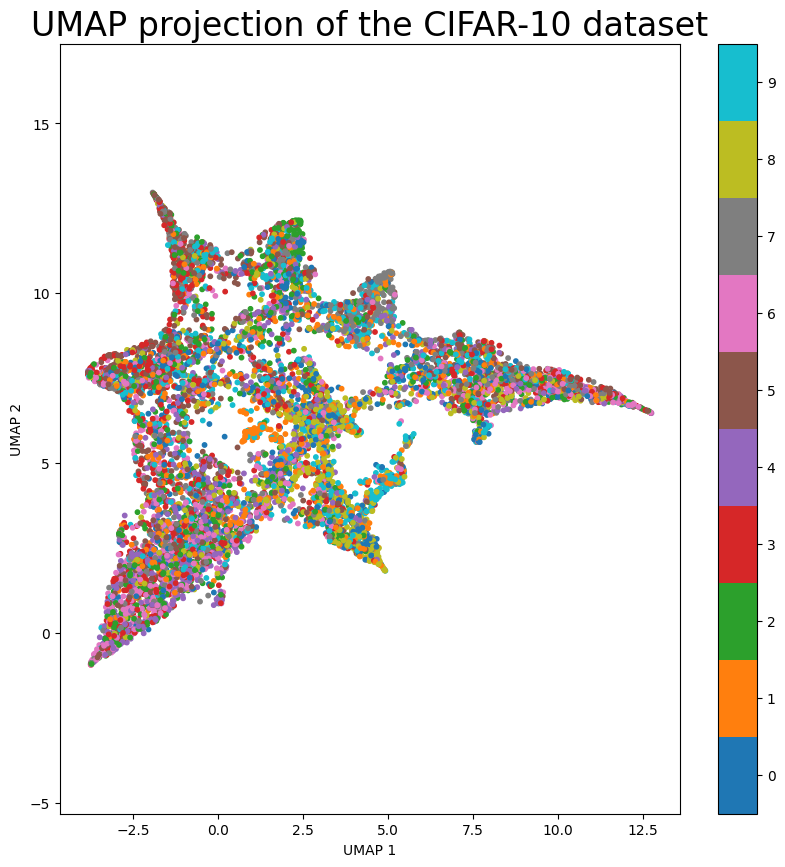

In [14]:
advx_features, advy_test = generate_fgm_examples(model, test_loader_augmented, criterion)
print(f"Original test loss: {average_test_loss}, accuracy: {test_acc}%")
plot_umap(advx_features, advy_test)

As expected, the model is not resistant to the FGSM attack and is therefore not able to classify images as well as before. That is why the projected features are mixed together (no more clusters) for the most part instead of having relatively distinct "spikes" like the previous case where there were no attacks. Next, we adversarially train our model to improve its robustness/resilience to attacks.

## Adversarial training

We will train the model using standard techniques with the addition of adversarial examples. The training process will involve the following steps:
1. Generate adversarial examples for the current batch of training data using FGSM.
2. Combine the adversarial examples with the original data to create an augmented training set.
3. Train the model on the augmented training set.

This approach ensures that the model learns from both clean and adversarial examples, improving its robustness.

Note: I've written the part for using a validation loader but am not using it because I kept running out of memory in Google Colab if I did.

In [15]:
from collections import defaultdict
import gc

gc.collect()
torch.cuda.empty_cache()

def train_and_validate_master(model, train_loader, optimizer, val_loader=None,
                              criterion=nn.CrossEntropyLoss(), epochs=100,
                              attack=False, epsilon=4/255, norm=np.inf):
    # Checks
    if (attack):
      assert 0 < epsilon
      assert norm == np.inf or norm == 1 or norm == 2

    report = defaultdict(list)
    for epoch in range(epochs):
        if (epoch % 3 == 0):
          print("Clear.")
          gc.collect()
          torch.cuda.empty_cache()

        # Training Phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training") as tbar:
            for batch_idx, (inputs, targets) in enumerate(tbar):
                inputs, targets = inputs.to(device), targets.to(device)
                report["test_features"].append(inputs)
                report["targets"].append(targets)

                if (attack):
                  # Generate adversarial examples
                  model.eval()  # Switch to eval mode for generating adversarial examples
                  # TODO: Maybe it'll be better to rename this to `inputs`?
                  adv_inputs = fast_gradient_method(model, inputs, epsilon, norm, targeted=False)
                  report["adv_features"].append(adv_inputs)
                  model.train()  # Switch back to train mode for the rest of the process

                # Generate predictions and backprop
                optimizer.zero_grad()
                outputs = model(adv_inputs if attack else inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                # Update statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)

                tbar.set_postfix(loss=(train_loss/(batch_idx + 1)), accuracy=100.*correct/total)

        train_loss /= len(train_loader)
        train_accuracy = 100. * correct / total
        report["train_loss"].append(train_loss)
        report["train_accuracy"].append(train_accuracy)

        if (val_loader):
          # Validation Phase
          model.eval()
          val_loss, correct, total = 0, 0, 0

          # NOTE: torch.no_grad() was causing errors in the fgm attack
          # because it needs to calculate the gradient
          # with torch.no_grad(), tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation") as vbar:
          with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation") as vbar:
              for batch_idx, (inputs, targets) in enumerate(vbar):
                  inputs, targets = inputs.to(device), targets.to(device)

                  if (attack):
                    # model is already in eval mode
                    # adv_inputs = fast_gradient_method(model, inputs, epsilon, norm, targeted=False)

                    # Ensure model is in eval mode, which it already is for validation
                    model.eval()
                    # Clone the inputs to avoid modifying the original data, then set requires_grad to True
                    inputs_adv = inputs.clone().detach().requires_grad_(True)
                    # Now, inputs_adv can have gradients computed for them
                    adv_inputs = fast_gradient_method(model, inputs_adv, epsilon, norm, targeted=False)


                  outputs = model(adv_inputs if attack else inputs)
                  loss = criterion(outputs, targets)

                  # Update statistics
                  val_loss += loss.item()
                  _, predicted = outputs.max(1)
                  correct += predicted.eq(targets).sum().item()
                  total += targets.size(0)

                  vbar.set_postfix(loss=(val_loss/(batch_idx + 1)), accuracy=100.*correct/total)

          val_loss /= len(val_loader)
          val_accuracy = 100. * correct / total
          report["val_loss"].append(val_loss)
          report["val_accuracy"].append(val_accuracy)

        if (epochs + 1) % 10 == 0:
          torch.save(model.state_dict(), "./model")

    report["model"] = model

    torch.save(model.state_dict(), 'q1_adv_model.pth')

    return report

NUM_WORKERS = 1 # Colab suggests at most 2 due to system limits

# Create augmented training and validation datasets
augmented_train_dataset = Cifar10Dataset(cifar_trainset, train_idx, transforms=augmentation)
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

augmented_val_dataset = Cifar10Dataset(cifar_trainset, val_idx_2, transforms=augmentation)
augmented_val_loader = torch.utils.data.DataLoader(augmented_val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

augmented_test_dataset = Cifar10Dataset(cifar_testset, list(range(len(cifar_testset))), transforms=augmentation)
augmented_test_loader = torch.utils.data.DataLoader(augmented_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

assert len(augmented_train_dataset) == 10000
assert len(augmented_val_dataset) == 2500
assert len(augmented_test_dataset) == 10000

robust_model = Resnet18(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(robust_model.parameters(), lr=0.001)

robust_model_report = train_and_validate_master(model=robust_model,
                                                train_loader=augmented_train_loader,
                                                # val_loader=augmented_val_loader,
                                                criterion=criterion,
                                                optimizer=optimizer,
                                                attack=True,
                                                epochs=15,
                                                epsilon=4/255,
                                                norm=np.inf)
print("\nDone.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clear.


Epoch 1/15 - Training:   0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 3/15 - Training: 100%|██████████| 157/157 [00:20<00:00,  7.69it/s, accuracy=42.3, loss=1.56]


Clear.


Epoch 6/15 - Training: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s, accuracy=47.3, loss=1.4]


Clear.


Epoch 9/15 - Training: 100%|██████████| 157/157 [00:20<00:00,  7.82it/s, accuracy=53, loss=1.24]


Clear.


Epoch 12/15 - Training: 100%|██████████| 157/157 [00:19<00:00,  7.93it/s, accuracy=56.7, loss=1.14]


Clear.


Epoch 15/15 - Training: 100%|██████████| 157/157 [00:19<00:00,  7.98it/s, accuracy=60.7, loss=1.01]


Done.


In [16]:
# Testing:
# 1. Test on clean test dataset
# 2. Test on adversarial examples generated from the test dataset

def test_adversarial(model, data_loader, criterion, optimizer, attack=False, epsilon=4/255, norm=np.inf):
    feature_extraction_model = nn.Sequential(
          model.resnet.conv1,
          model.resnet.bn1,
          model.resnet.relu,
          model.resnet.maxpool,
          model.resnet.layer1,
          model.resnet.layer2,
          model.resnet.layer3,
          model.resnet.layer4,
          model.resnet.avgpool
      )

    # Switch to evaluation mode
    feature_extraction_model.eval().to(device)

    features = []
    labels = []

    average_test_loss = 0.
    correct_predictions = 0
    total_predictions = 0

    # Switch to evaluation mode
    model.eval()

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)

            if (attack):
              inputs = fast_gradient_method(model, inputs, epsilon, norm, targeted=False)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            average_test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_predictions += predicted.eq(targets).sum().item()
            total_predictions += targets.size(0)

            # Extract features from perturbed data for plotting
            feature_outputs = feature_extraction_model(inputs)
            outputs_reshaped = feature_outputs.view(feature_outputs.size(0), -1).detach().cpu().numpy()
            features.append(outputs_reshaped)
            labels.append(targets.cpu().numpy())

            test_tqdm.set_postfix({
                'loss': average_test_loss/(batch_idx+1),
                'accuracy': 100. * correct_predictions / total_predictions
            })

    average_test_loss /= len(data_loader)
    accuracy = 100. * correct_predictions / total_predictions

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels, average_test_loss, accuracy

Now, we test the adversarially trained model on two datasets:
1. A clean dataset: This is to gauge the accuracy on regular, unperturbed data. We expect this to go down.
2. A poisoned dataset: This is to gauge the accuracy on attacked data. We expect this to go up.

   test: 100%|██████████| 157/157 [00:19<00:00,  8.11it/s, loss=1.4, accuracy=54.9]
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clean test data results: Loss: 1.402, Accuracy: 54.90%


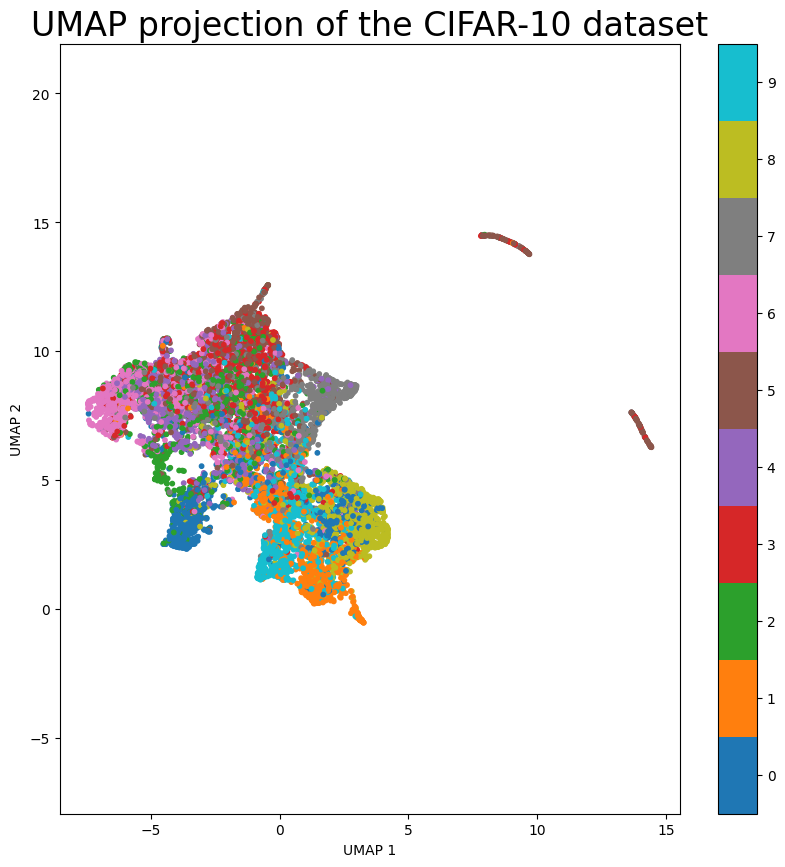

In [17]:
# test_features, y_test = extract_features(robust_model_report["model"], augmented_test_loader) # robust_model_report["targets"]

gc.collect()
torch.cuda.empty_cache()

# Test on clean data
clean_features, clean_labels, clean_test_loss, clean_test_acc = test_adversarial(model=robust_model_report["model"],
                                                                                 data_loader=augmented_test_loader,
                                                                                 criterion=criterion,
                                                                                 optimizer=optimizer,
                                                                                 attack=False)
print(f"Clean test data results: Loss: {clean_test_loss:.3f}, Accuracy: {clean_test_acc:.2f}%")
plot_umap(clean_features, clean_labels)

   test:   0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
   test: 100%|██████████| 157/157 [00:19<00:00,  7.95it/s, loss=1.49, accuracy=45.5]
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Adversarial testing completed. Loss: 1.4893, Accuracy: 45.48%


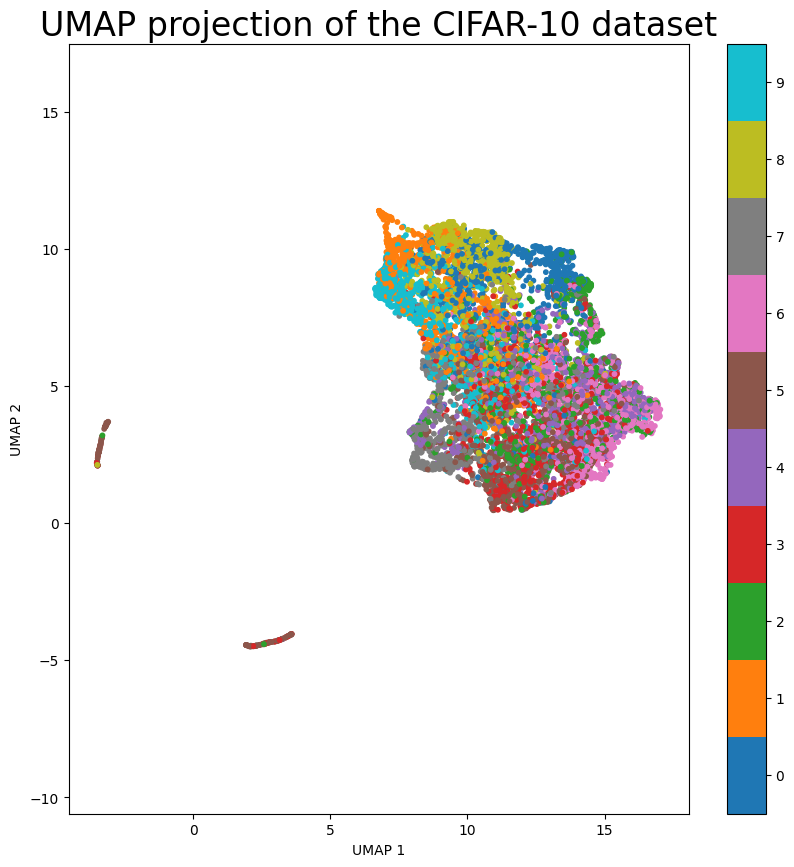

In [18]:
adv_features, advy_test, average_adv_test_loss, adv_test_acc = test_adversarial(model=robust_model_report["model"],
                                                                                data_loader=augmented_test_loader,
                                                                                criterion=criterion,
                                                                                optimizer=optimizer,
                                                                                attack=True,
                                                                                epsilon=4/255,
                                                                                norm=np.inf)

print(f"Adversarial testing completed. Loss: {average_adv_test_loss:.4f}, Accuracy: {adv_test_acc:.2f}%")

plot_umap(adv_features, advy_test)

We evaluate the model twice, with and without the FGSM attack. Notice that the test accuracy on the "clean" data has dropped, whereas the test accuracy on the adversarial test data has risen. This means the model has traded some classification accuracy for robustness, an expected trade-off.

In [19]:
# Clean up

# Delete optimizers
del optimizer

# Delete model
# del model
# del robust_model

# Delete data loaders
del augmented_train_loader
del augmented_test_loader
del augmented_val_loader

# Delete criterion
del criterion

# Other
del robust_model_report, clean_features, clean_labels, clean_test_loss, clean_test_acc, adv_features, advy_test, average_adv_test_loss, adv_test_acc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize(device=device)